<a href="https://colab.research.google.com/github/parikshithsivakumar/NLP/blob/main/final_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Suppress WandB logging
os.environ["WANDB_DISABLED"] = "true"

# Upload Dataset in Colab
# uploaded = files.upload()  # This will prompt for file upload
# file_name = list(uploaded.keys())[0]  # Get the uploaded file name

# Load the dataset
# data = pd.read_csv(file_name)


data = pd.read_csv("mine_dataset.csv")
# Select the columns and rename
df = data[['cleaned_text', 'Sentiment']].rename(columns={'cleaned_text': 'text'})

# Map Sentiment values to numeric categories
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Stratified Split for Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

# Load XLM-RoBERTa Tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': self.labels[idx],
        }

# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)

# Load Pre-trained XLM-RoBERTa Model
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=3  # Match the number of sentiment classes
)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    learning_rate=2e-5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",  # Disable WandB
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the Model
trainer.train()

# Evaluate the Model
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Calculate Metrics
f1 = f1_score(val_labels, pred_labels, average='weighted')
classification_report_data = classification_report(val_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive'])

# Print Metrics
print(f"Weighted F1 Score: {f1}")
print(classification_report_data)

# Save the Fine-Tuned Model
model_save_path = "fine_tuned_xlm_roberta_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved at: {model_save_path}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-1-9a35fcdcfc14>:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.019700,0.798279
2,0.729300,0.595675
3,0.529400,0.526136
4,0.437300,0.551180
5,0.279200,0.550182
6,0.313000,0.561048


Weighted F1 Score: 0.801226751088247
              precision    recall  f1-score   support

    Negative       0.83      0.86      0.84        56
     Neutral       0.81      0.68      0.74        38
    Positive       0.77      0.83      0.80        58

    accuracy                           0.80       152
   macro avg       0.80      0.79      0.79       152
weighted avg       0.80      0.80      0.80       152

Model saved at: fine_tuned_xlm_roberta_model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-2-18a21f86fa5e>:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.059200,0.904775
2,0.817500,0.640270
3,0.573000,0.578310
4,0.560800,0.567950
5,0.423200,0.509196
6,0.414200,0.524449


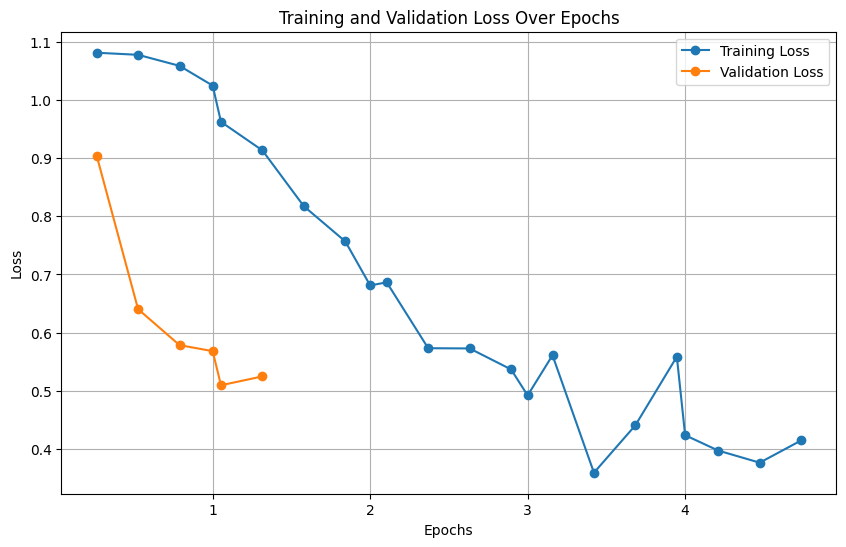

Weighted F1 Score: 0.8290370329844015
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86        56
     Neutral       0.76      0.76      0.76        38
    Positive       0.83      0.84      0.84        58

    accuracy                           0.83       152
   macro avg       0.82      0.82      0.82       152
weighted avg       0.83      0.83      0.83       152

Model saved at: fine_tuned_xlm_roberta_model


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt

# Suppress WandB logging
os.environ["WANDB_DISABLED"] = "true"

# Load the dataset
data = pd.read_csv("mine_dataset.csv")

# Select the columns and rename
df = data[['cleaned_text', 'Sentiment']].rename(columns={'cleaned_text': 'text'})

# Map Sentiment values to numeric categories
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Stratified Split for Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

# Load XLM-RoBERTa Tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': self.labels[idx],
        }

# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)

# Load Pre-trained XLM-RoBERTa Model
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=3  # Match the number of sentiment classes
)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    learning_rate=2e-5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",  # Disable WandB
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the Model
trainer.train()

# Get Training Logs
training_logs = trainer.state.log_history

# Extract Metrics for Plotting
epochs = []
train_loss = []
eval_loss = []
eval_f1 = []

for log in training_logs:
    if "loss" in log:  # Training loss
        train_loss.append(log["loss"])
    if "eval_loss" in log:  # Validation loss
        eval_loss.append(log["eval_loss"])
    if "eval_f1" in log:  # F1 score during evaluation
        eval_f1.append(log["eval_f1"])
    if "epoch" in log:
        epochs.append(log["epoch"])

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker="o")
if eval_loss:
    plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Validation F1 Score (if available)
if eval_f1:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs[:len(eval_f1)], eval_f1, label="Validation F1 Score", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate the Model
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Calculate Metrics
f1 = f1_score(val_labels, pred_labels, average='weighted')
classification_report_data = classification_report(val_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive'])

# Print Metrics
print(f"Weighted F1 Score: {f1}")
print(classification_report_data)

# Save the Fine-Tuned Model
model_save_path = "fine_tuned_xlm_roberta_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved at: {model_save_path}")


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-3-6a6508a048d8>:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.888900,0.802122
2,0.822500,0.689570
3,0.514500,0.567862
4,0.601500,0.570705
5,0.420100,0.635482
6,0.202500,0.820849
7,0.345100,0.837839
8,0.226200,0.857229
9,0.111200,0.872856


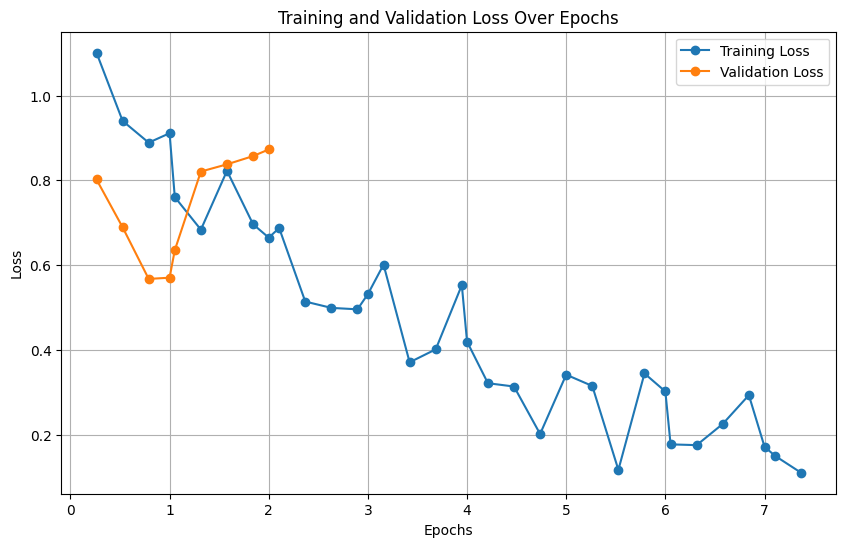

Weighted F1 Score: 0.7951304585046475
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86        56
     Neutral       0.71      0.66      0.68        38
    Positive       0.77      0.83      0.80        58

    accuracy                           0.80       152
   macro avg       0.79      0.78      0.78       152
weighted avg       0.80      0.80      0.80       152

Model saved at: fine_tuned_siebert_model


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt

# Suppress WandB logging
os.environ["WANDB_DISABLED"] = "true"

# Load Dataset
data = pd.read_csv("mine_dataset.csv")

# Select the columns and rename
df = data[['cleaned_text', 'Sentiment']].rename(columns={'cleaned_text': 'text'})

# Map Sentiment values to numeric categories
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Stratified Split for Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

# Load Tokenizer for Siebert's Model
tokenizer = RobertaTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx],
        }

# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)

# Load Pre-trained Siebert Model with Fix
model = RobertaForSequenceClassification.from_pretrained(
    "siebert/sentiment-roberta-large-english",
    num_labels=3,  # Match the number of sentiment classes
    ignore_mismatched_sizes=True  # Allow resizing of the classifier layer
)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=9,
    learning_rate=2e-5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",  # Disable WandB
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Train the Model
trainer.train()

# Extract Metrics for Plotting
training_logs = trainer.state.log_history

# Variables to store metrics for plotting
epochs = []
train_loss = []
eval_loss = []
eval_f1 = []

# Parse log history for relevant metrics
for log in training_logs:
    if "loss" in log:  # Training loss
        train_loss.append(log["loss"])
    if "eval_loss" in log:  # Validation loss
        eval_loss.append(log["eval_loss"])
    if "eval_f1" in log:  # Validation F1 score
        eval_f1.append(log["eval_f1"])
    if "epoch" in log and log["epoch"] not in epochs:  # Epochs
        epochs.append(log["epoch"])

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker="o")
if eval_loss:
    plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Validation F1 Score (if available)
if eval_f1:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs[:len(eval_f1)], eval_f1, label="Validation F1 Score", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate the Model
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Calculate Metrics
f1 = f1_score(val_labels, pred_labels, average='weighted')
classification_report_data = classification_report(val_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive'])

# Print Metrics
print(f"Weighted F1 Score: {f1}")
print(classification_report_data)

# Save the Fine-Tuned Model
model_save_path = "fine_tuned_siebert_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved at: {model_save_path}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.885300,0.772780
2,0.584400,0.550022
3,0.454800,0.505755
4,0.349500,0.490019
5,0.284200,0.469892


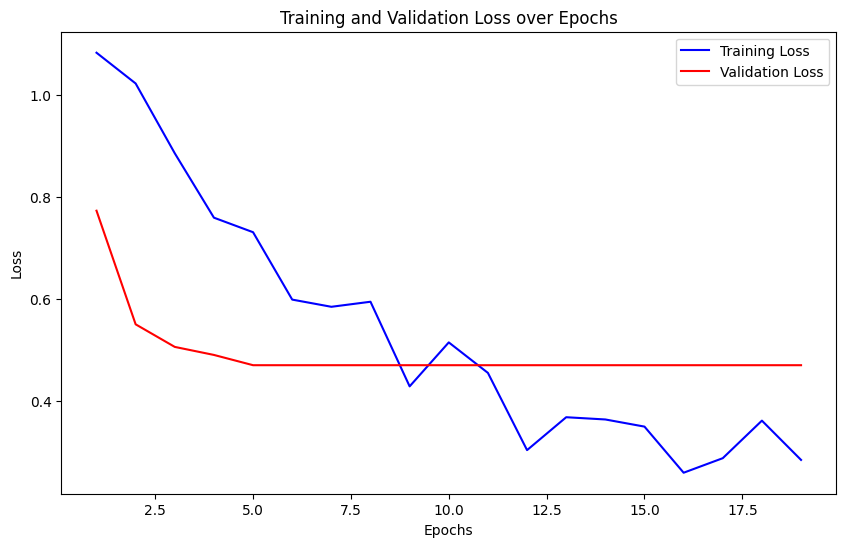

F1 Score: 0.8127911993097497
              precision    recall  f1-score   support

    Negative       0.84      0.93      0.89        58
     Neutral       0.81      0.67      0.73        33
    Positive       0.79      0.79      0.79        61

    accuracy                           0.82       152
   macro avg       0.82      0.79      0.80       152
weighted avg       0.81      0.82      0.81       152



('./fine_tuned_distilbert/tokenizer_config.json',
 './fine_tuned_distilbert/special_tokens_map.json',
 './fine_tuned_distilbert/vocab.txt',
 './fine_tuned_distilbert/added_tokens.json')

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.utils.data import Dataset

# Suppress WandB logging if not required
os.environ["WANDB_DISABLED"] = "true"

# Load Dataset
data = pd.read_csv("mine_dataset.csv")

# Select the columns and rename
df = data[['cleaned_text', 'Sentiment']].rename(columns={'cleaned_text': 'text'})

# Map Sentiment values to numeric categories
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Split Dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)

# Load Pre-trained Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    run_name="distilbert_deforestation_sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
)

# Custom Callback to Capture Loss
class LossLogger(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])

# Create an instance of the callback
loss_logger = LossLogger()

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[loss_logger]  # Add the callback
)

# Train the Model
trainer.train()

# Plot Loss
epochs = range(1, len(loss_logger.train_losses) + 1)

# If eval_losses is shorter, repeat the last value to match the number of epochs
if len(loss_logger.eval_losses) < len(loss_logger.train_losses):
    loss_logger.eval_losses.extend([loss_logger.eval_losses[-1]] * (len(loss_logger.train_losses) - len(loss_logger.eval_losses)))

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_logger.train_losses, label='Training Loss', color='blue')
plt.plot(epochs, loss_logger.eval_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
f1 = f1_score(val_labels, pred_labels, average='weighted')
print("F1 Score:", f1)

print(classification_report(val_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive']))

# Save the Model
model.save_pretrained('./fine_tuned_distilbert')
tokenizer.save_pretrained('./fine_tuned_distilbert')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-870a1f7ab85f>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.940800,0.681616
2,0.577000,0.520888
3,0.391300,0.499645
4,0.329300,0.526062
5,0.210500,0.506941


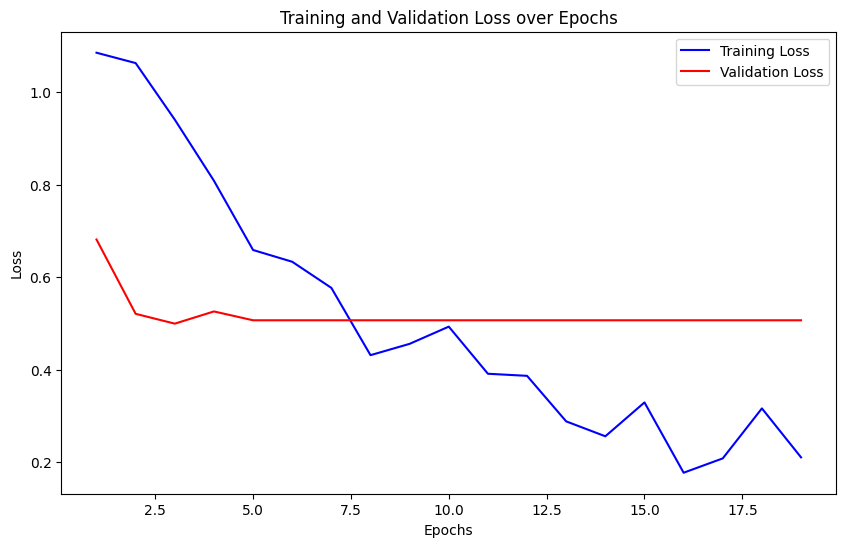

Weighted F1 Score: 0.8273406149512345
              precision    recall  f1-score   support

    Negative       0.85      0.93      0.89        56
     Neutral       0.78      0.74      0.76        38
    Positive       0.84      0.79      0.81        58

    accuracy                           0.83       152
   macro avg       0.82      0.82      0.82       152
weighted avg       0.83      0.83      0.83       152

Model saved at: fine_tuned_roberta_model


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.utils.data import Dataset
import torch

# Suppress WandB logging
os.environ["WANDB_DISABLED"] = "true"

# Load Dataset
data = pd.read_csv("mine_dataset.csv")
# Select the columns and rename
df = data[['cleaned_text', 'Sentiment']].rename(columns={'cleaned_text': 'text'})

# Map Sentiment values to numeric categories
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Stratified Split for Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)

# Load RoBERTa Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': self.labels[idx],
        }

# Create Datasets
train_dataset = SentimentDataset(train_texts, train_labels)
val_dataset = SentimentDataset(val_texts, val_labels)

# Load Pre-trained RoBERTa Model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3  # Match the number of sentiment classes
)

# Custom Callback to Capture Loss
class LossLogger(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])

# Create an instance of the callback
loss_logger = LossLogger()

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.1,
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",  # Disable WandB
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_logger],  # Add the callback
)

# Train the Model
trainer.train()

# Plot Training and Validation Loss
epochs = range(1, len(loss_logger.train_losses) + 1)

# If eval_losses is shorter, repeat the last value to match the number of epochs
if len(loss_logger.eval_losses) < len(loss_logger.train_losses):
    loss_logger.eval_losses.extend([loss_logger.eval_losses[-1]] * (len(loss_logger.train_losses) - len(loss_logger.eval_losses)))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_logger.train_losses, label='Training Loss', color='blue')
plt.plot(epochs, loss_logger.eval_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Calculate Metrics
f1 = f1_score(val_labels, pred_labels, average='weighted')
classification_report_data = classification_report(val_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive'])

# Print Metrics
print(f"Weighted F1 Score: {f1}")
print(classification_report_data)

# Save the Fine-Tuned Model
model_save_path = "fine_tuned_roberta_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved at: {model_save_path}")
